In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import scipy.io as sio
import skimage.io

In [2]:
path_raw_image = "../Data/090085_20170531.h5"
path_road_mask = "../Data/090085_with_uncl.tif"

In [3]:
# read in raw image
raw_image = np.array(h5py.File(path_raw_image)['scene'])

# read in road mask
road_img = skimage.io.imread(path_road_mask)

# re-scale to {0,1}
road_img[np.where(road_img == 255)] = 1
assert (np.logical_or(road_img == 1, road_img == 0)).all()

In [4]:
print(type(raw_image), raw_image.shape)
print(type(raw_image), road_img.shape)

<class 'numpy.ndarray'> (7, 7961, 8091)
<class 'numpy.ndarray'> (7961, 8091)


In [5]:
def show_image_against_road(x,y,image=raw_image, road=road_img, light=3.0, size=500, figsize=(20,20)):
    sub_road = road[x:x+size,y:y+size]
    sub_road[np.where(sub_road == 255)] = 1
    raw_image
    sub_image = image[[1,2,3],x:x+size,y:y+size]
    sub_image = sub_image/10000*light
    for img in sub_image:
        img[np.where(img<0)] = 0
        img[np.where(img>1)] = 1
    
    patch = np.array([sub_image[2].T, sub_image[1].T, sub_image[0].T]).T
    plt.figure(figsize=figsize)
    plt.imshow(patch)
    plt.show()
    plt.clf()

    sub_image[2][np.where(sub_road == 1)] = 1
    sub_image[1][np.where(sub_road == 1)] = 0
    sub_image[0][np.where(sub_road == 1)] = 0
    patch = np.array([sub_image[2].T, sub_image[1].T, sub_image[0].T]).T
    plt.figure(figsize=figsize)
    plt.imshow(patch)
    plt.show()
    plt.clf()

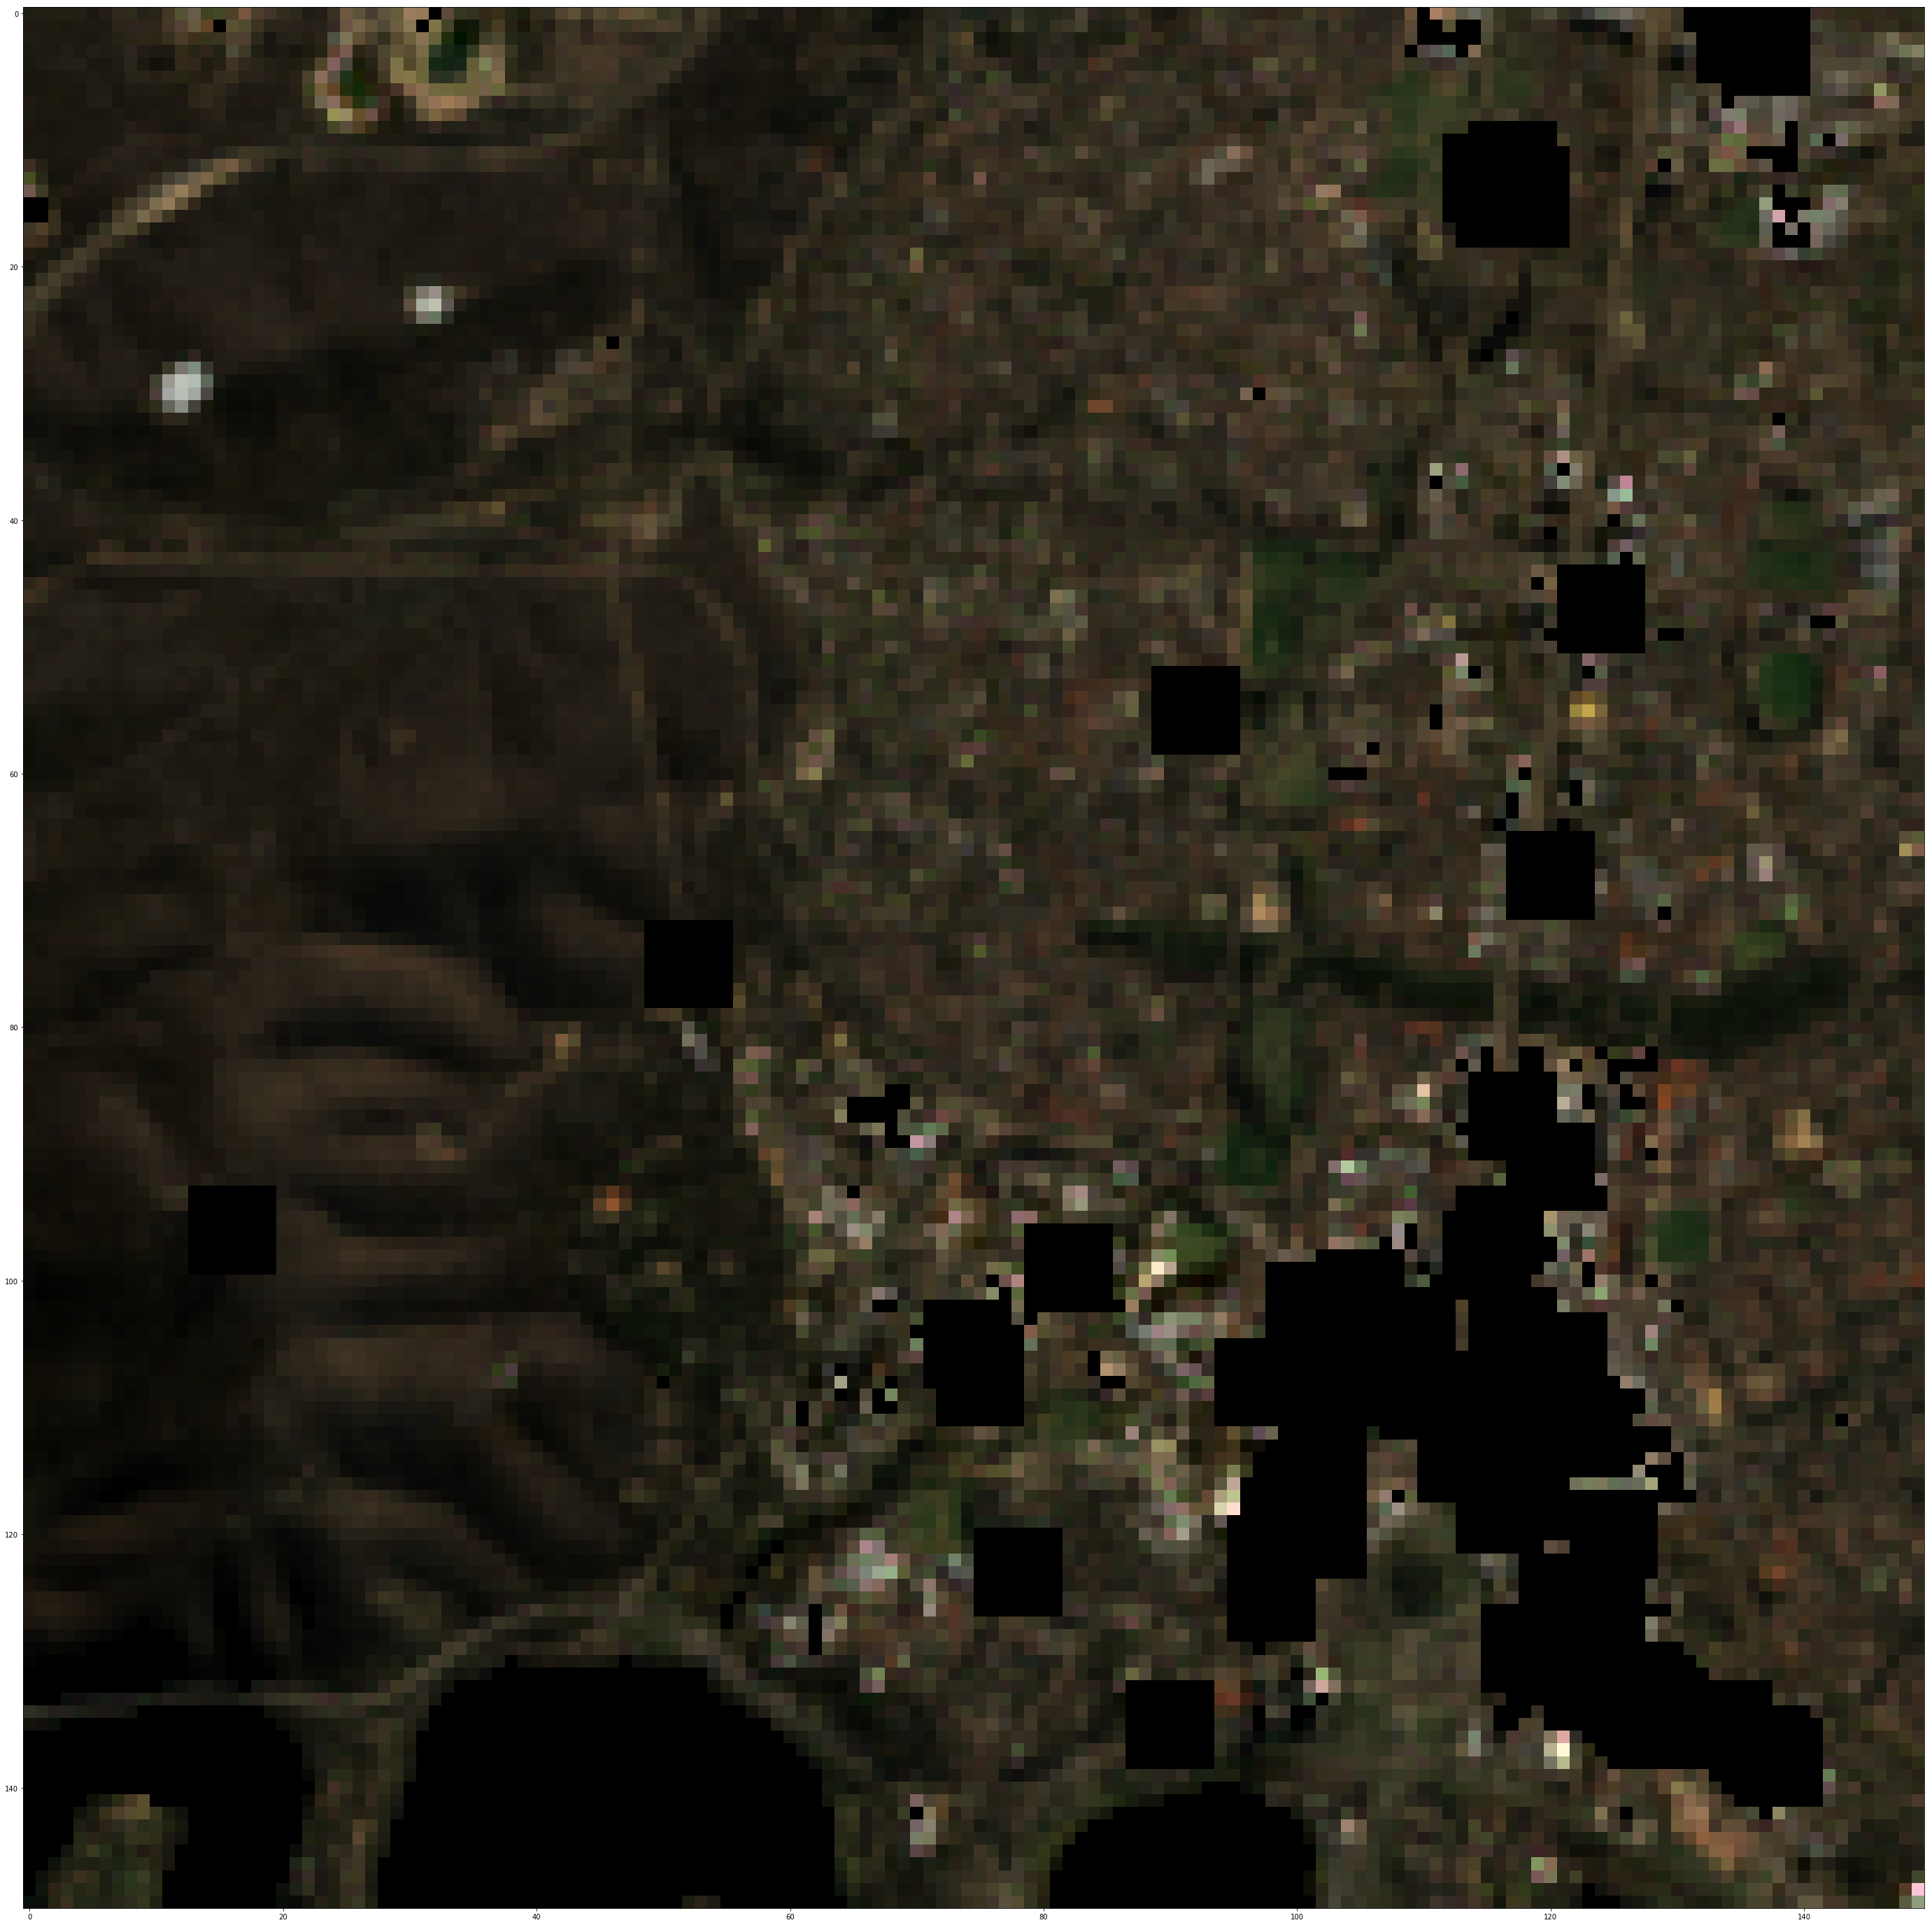

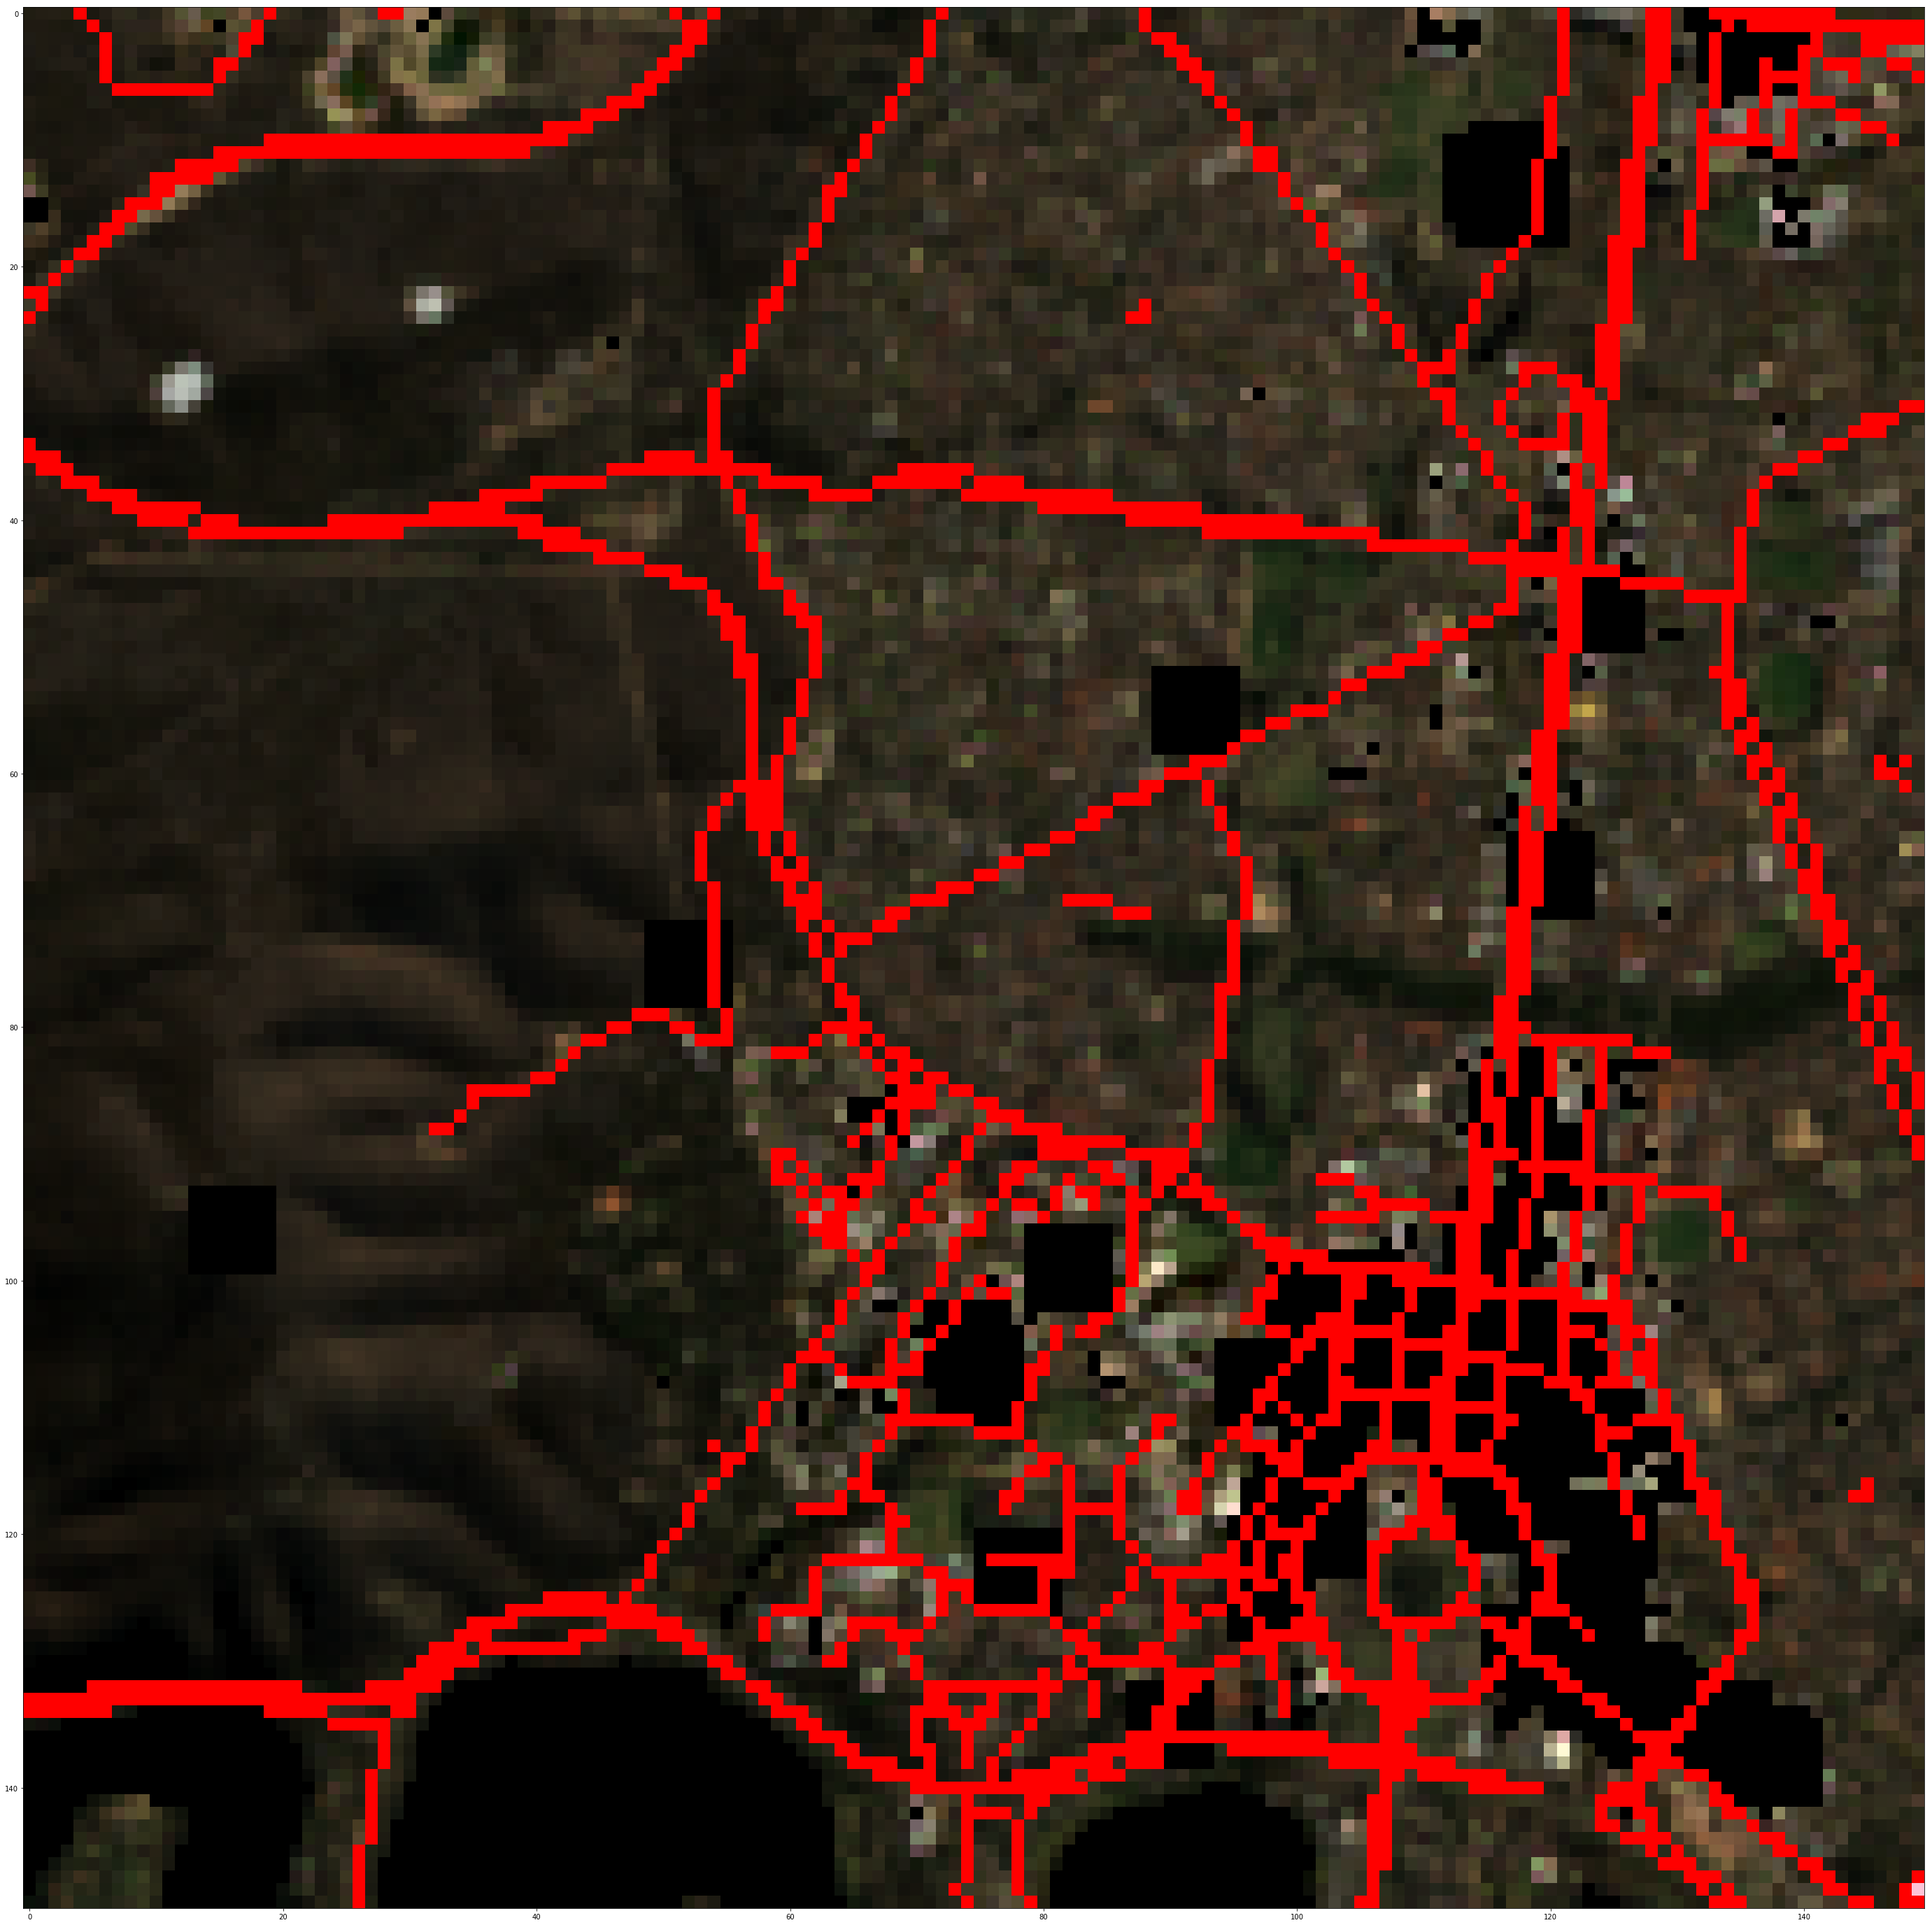

In [22]:
show_image_against_road(1160-150,3100-30, light=3, size=150, figsize=(50,50))

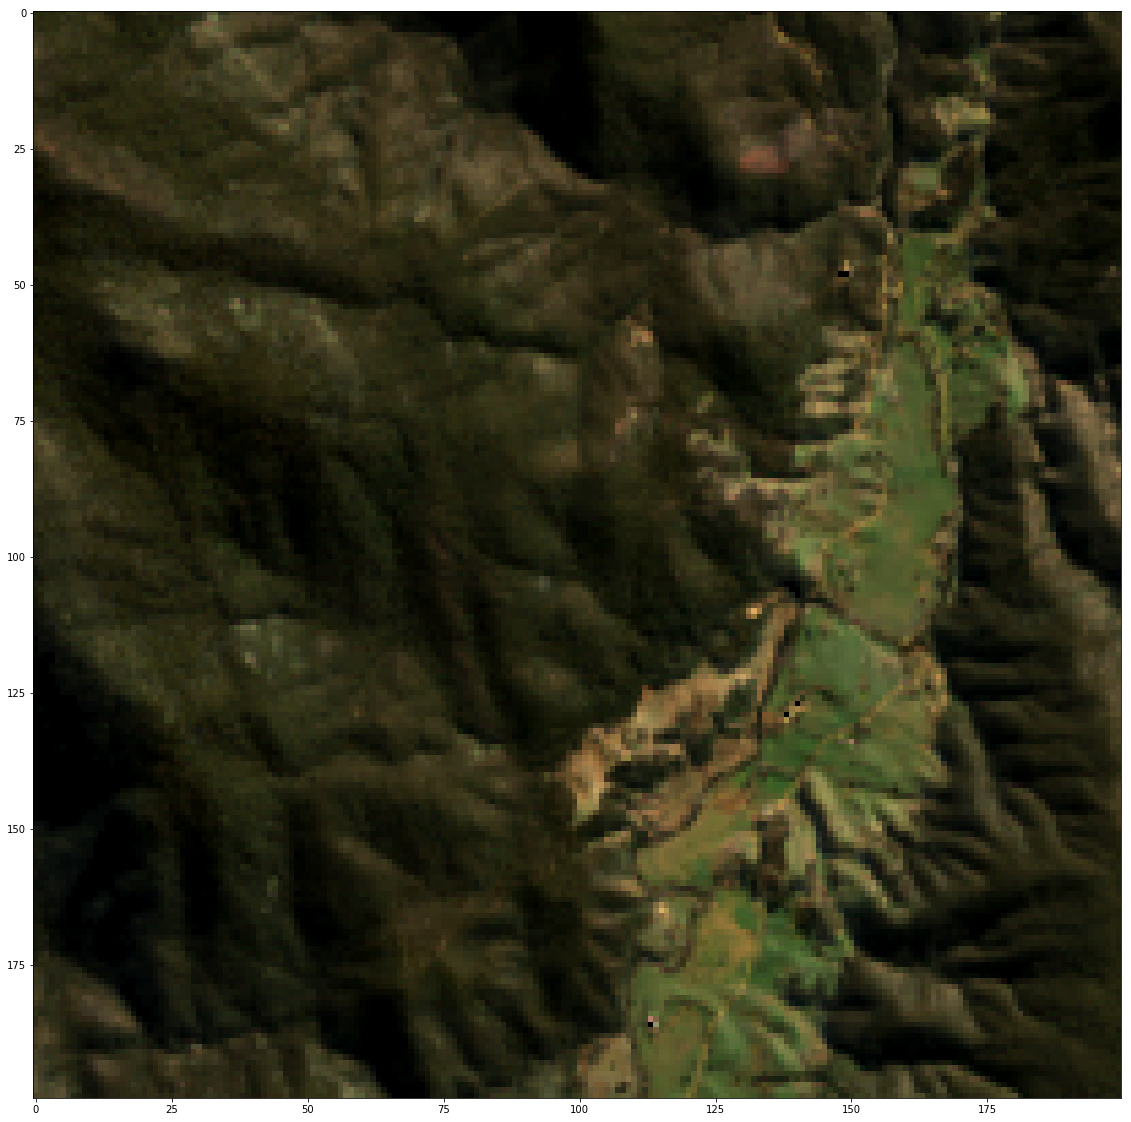

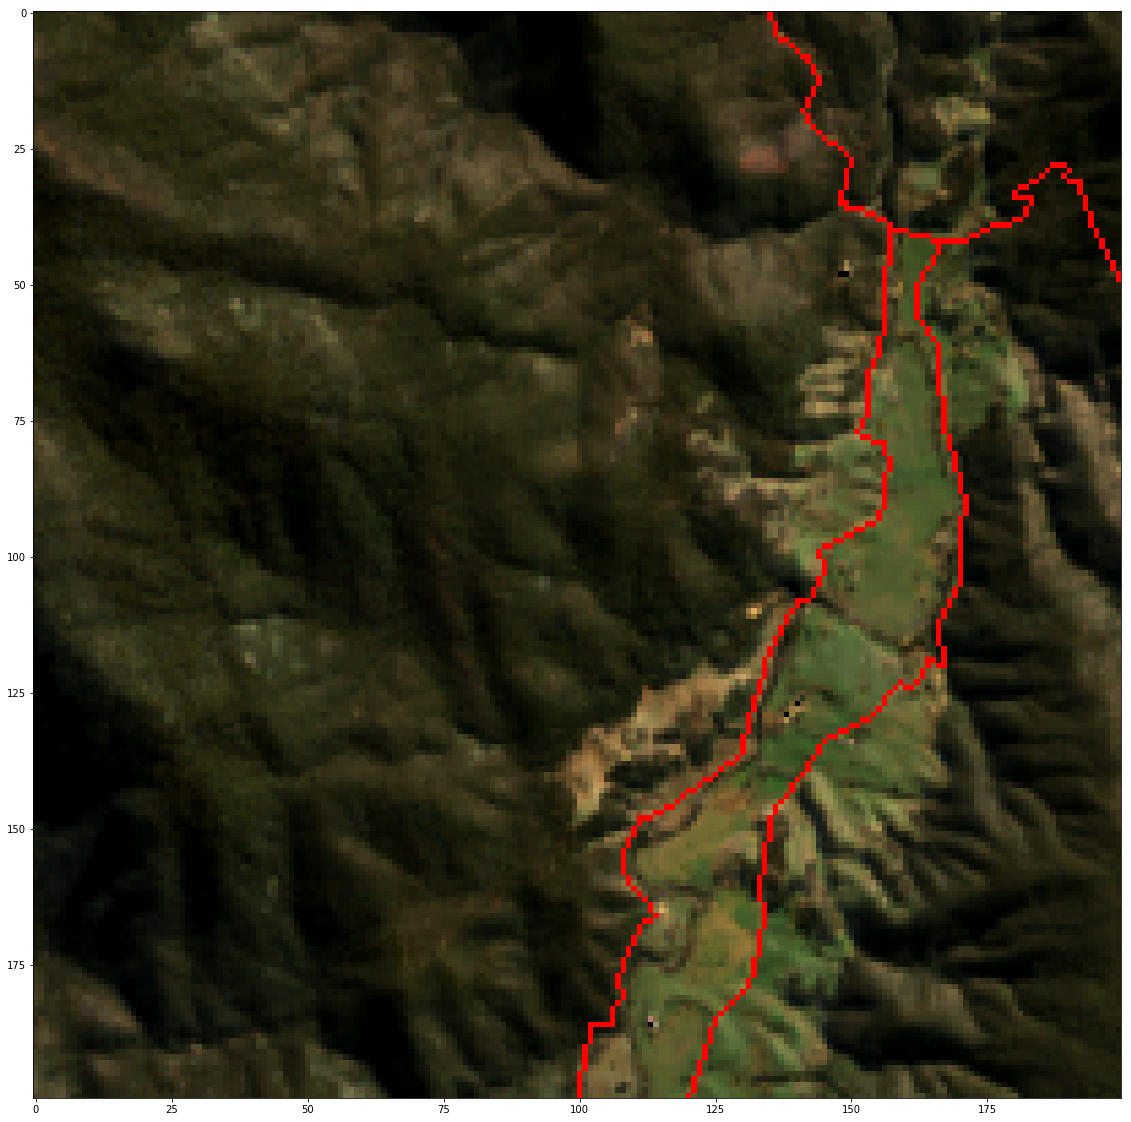

In [7]:
show_image_against_road(1450,1850, light=6, size=200)

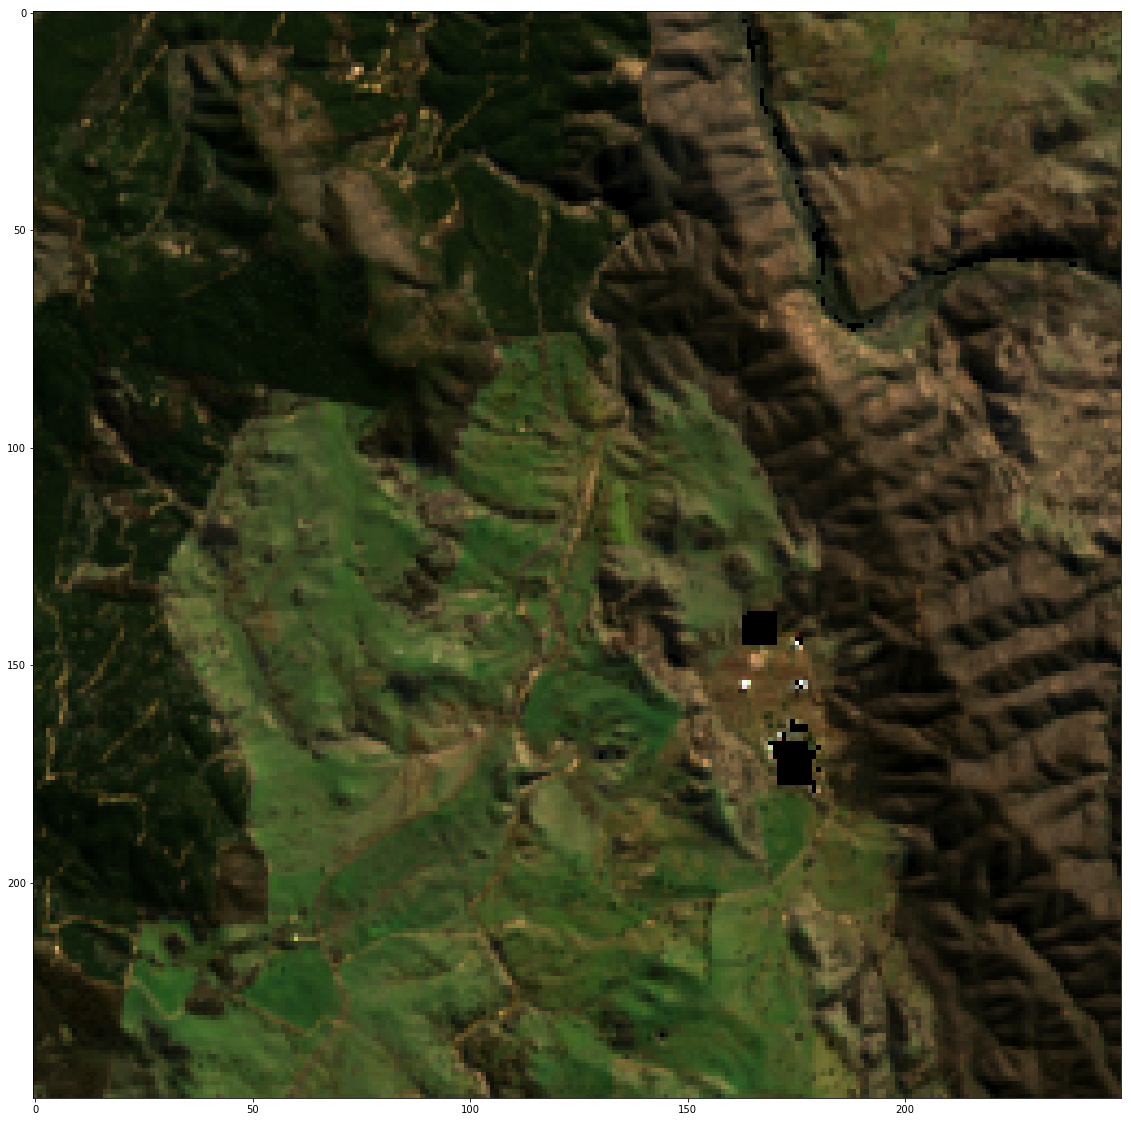

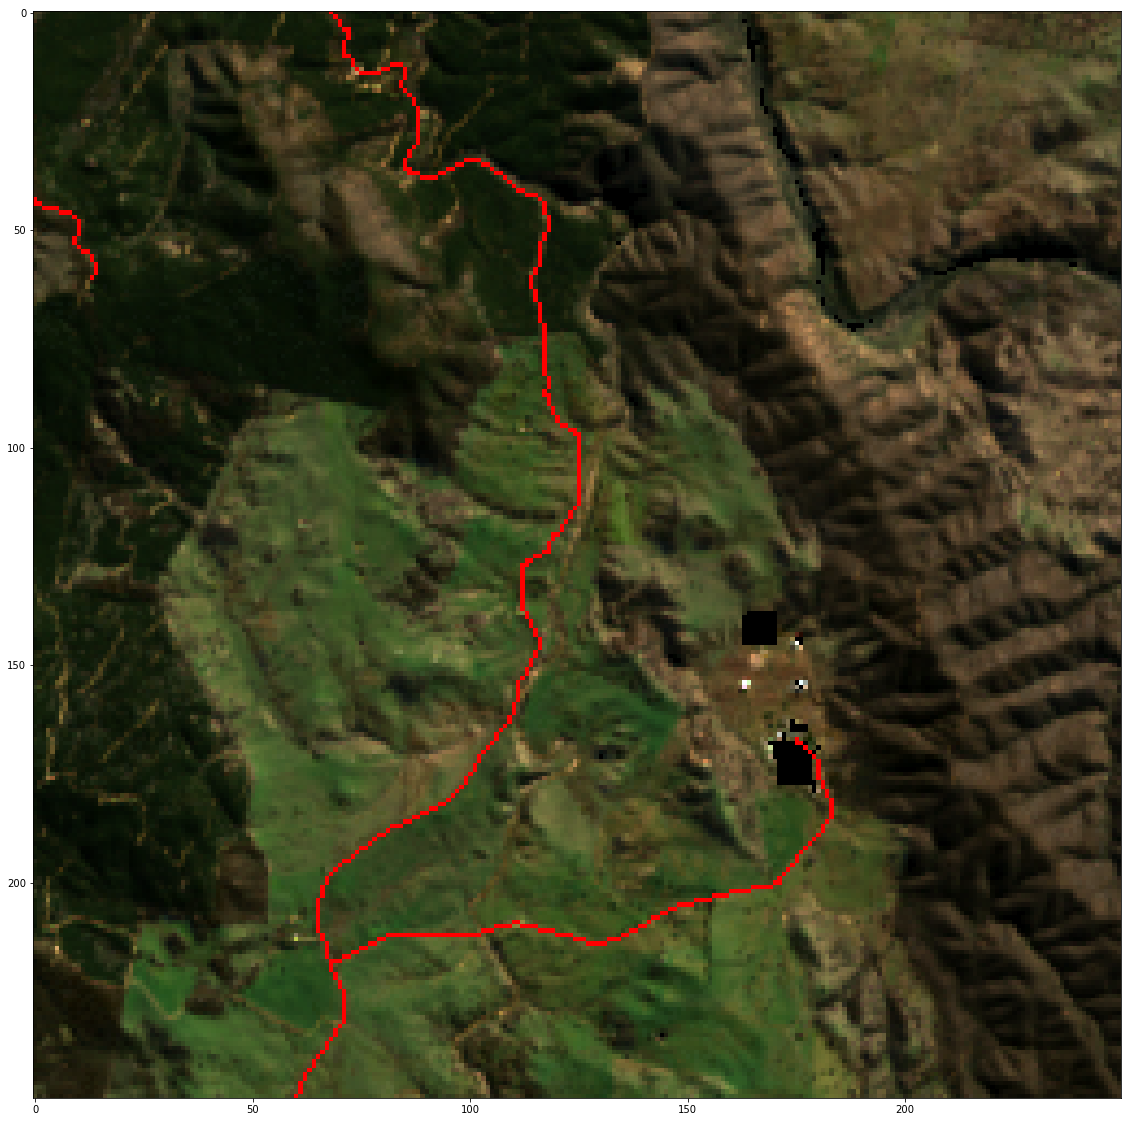

In [8]:
show_image_against_road(1400,2550, light=5, size=250)

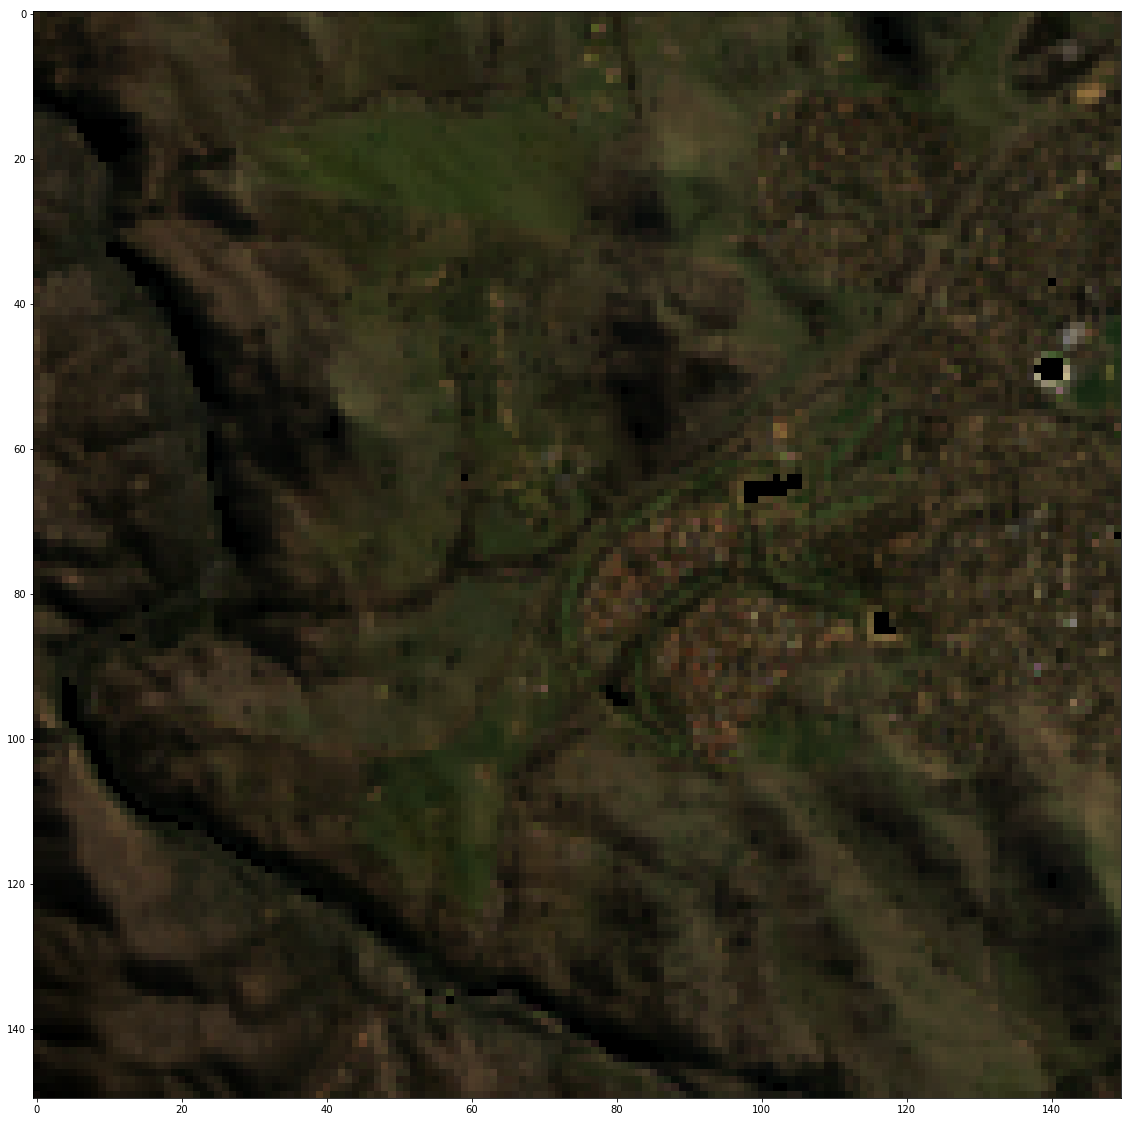

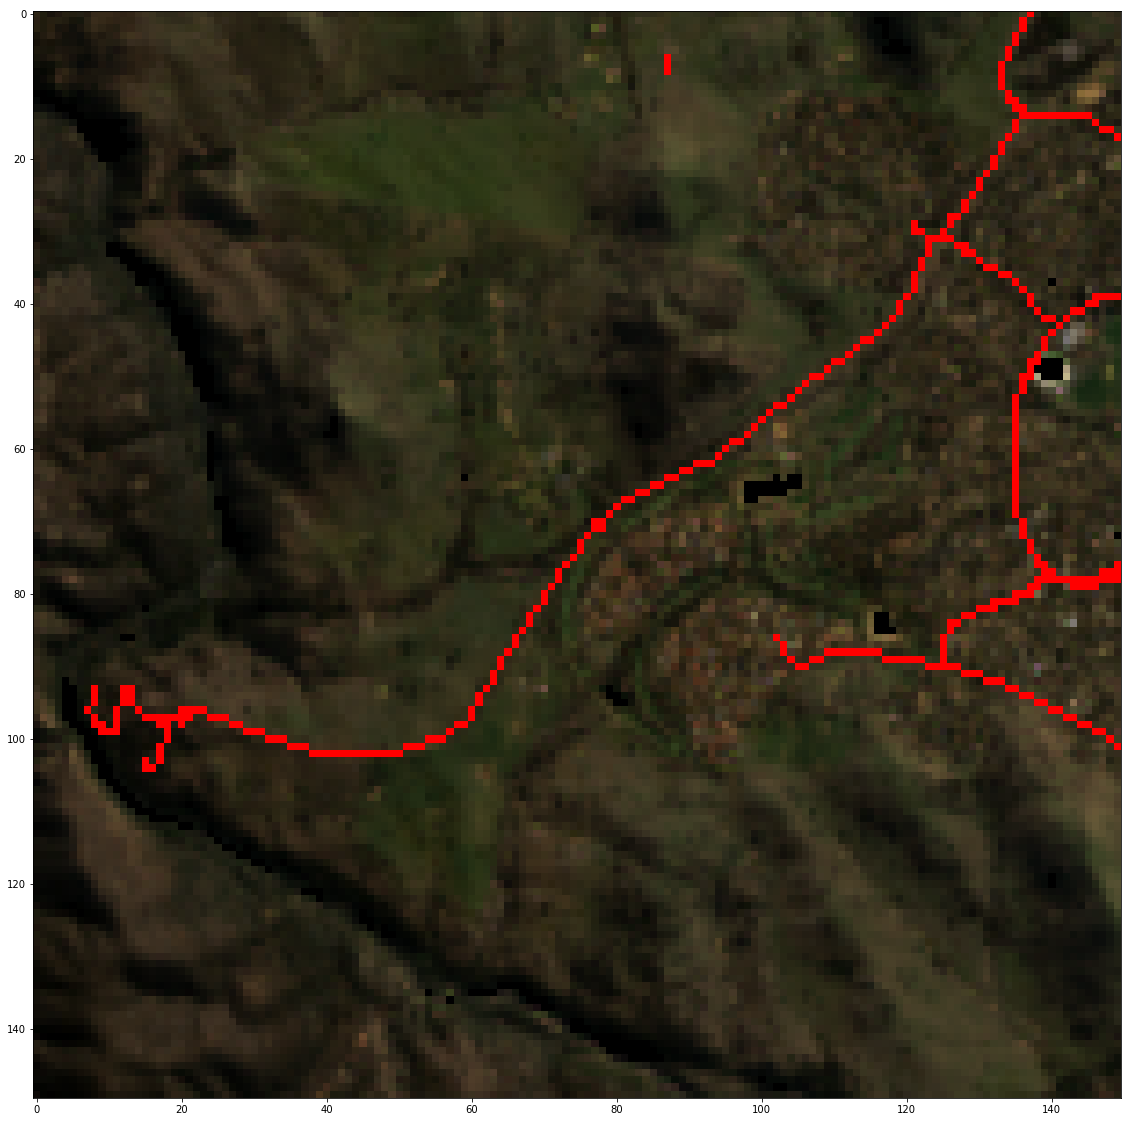

In [9]:
show_image_against_road(1450,2800, light=3, size=150)

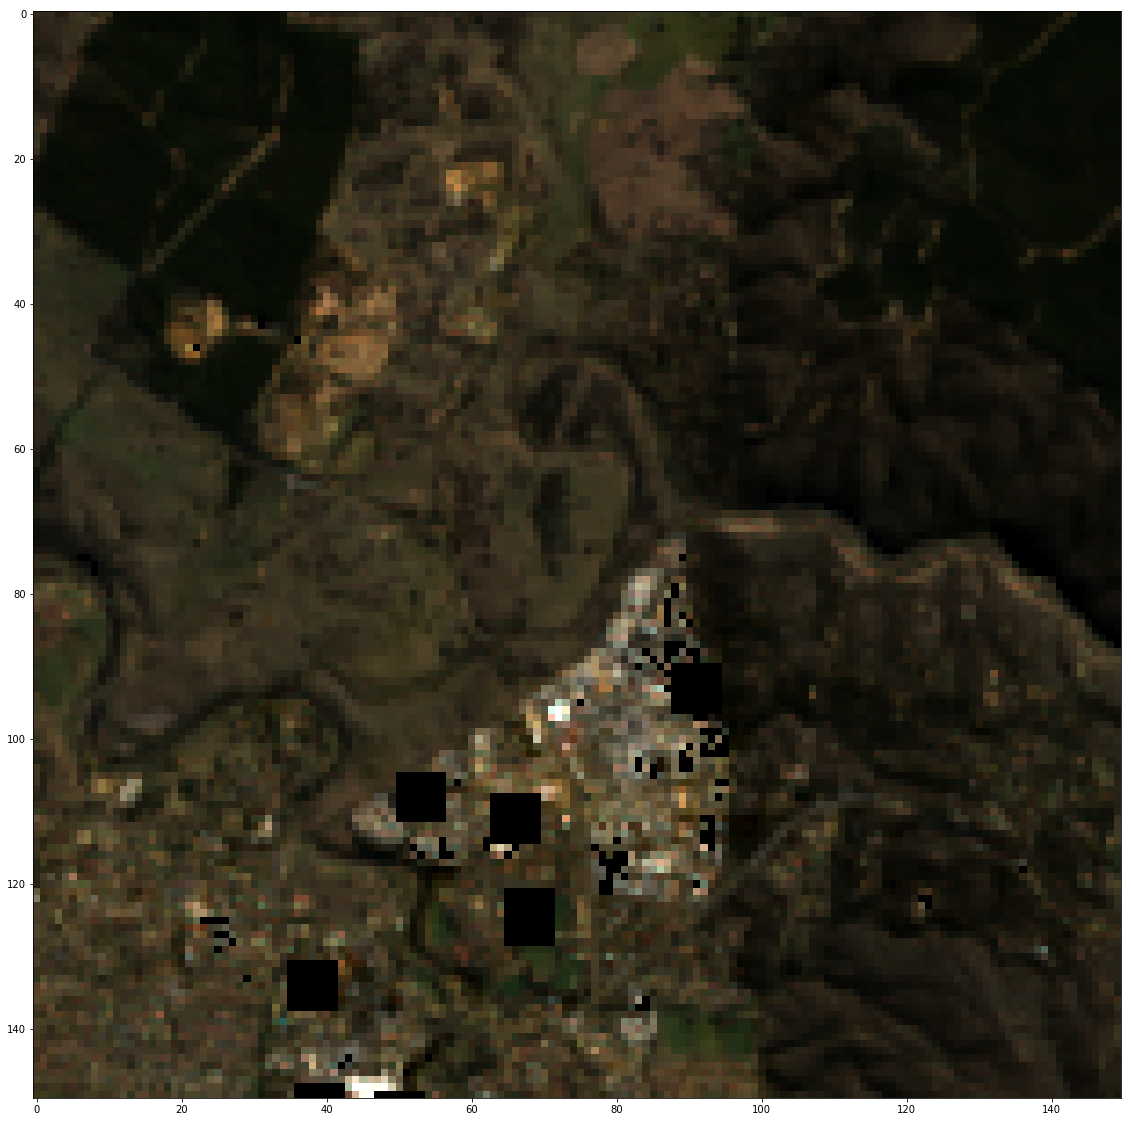

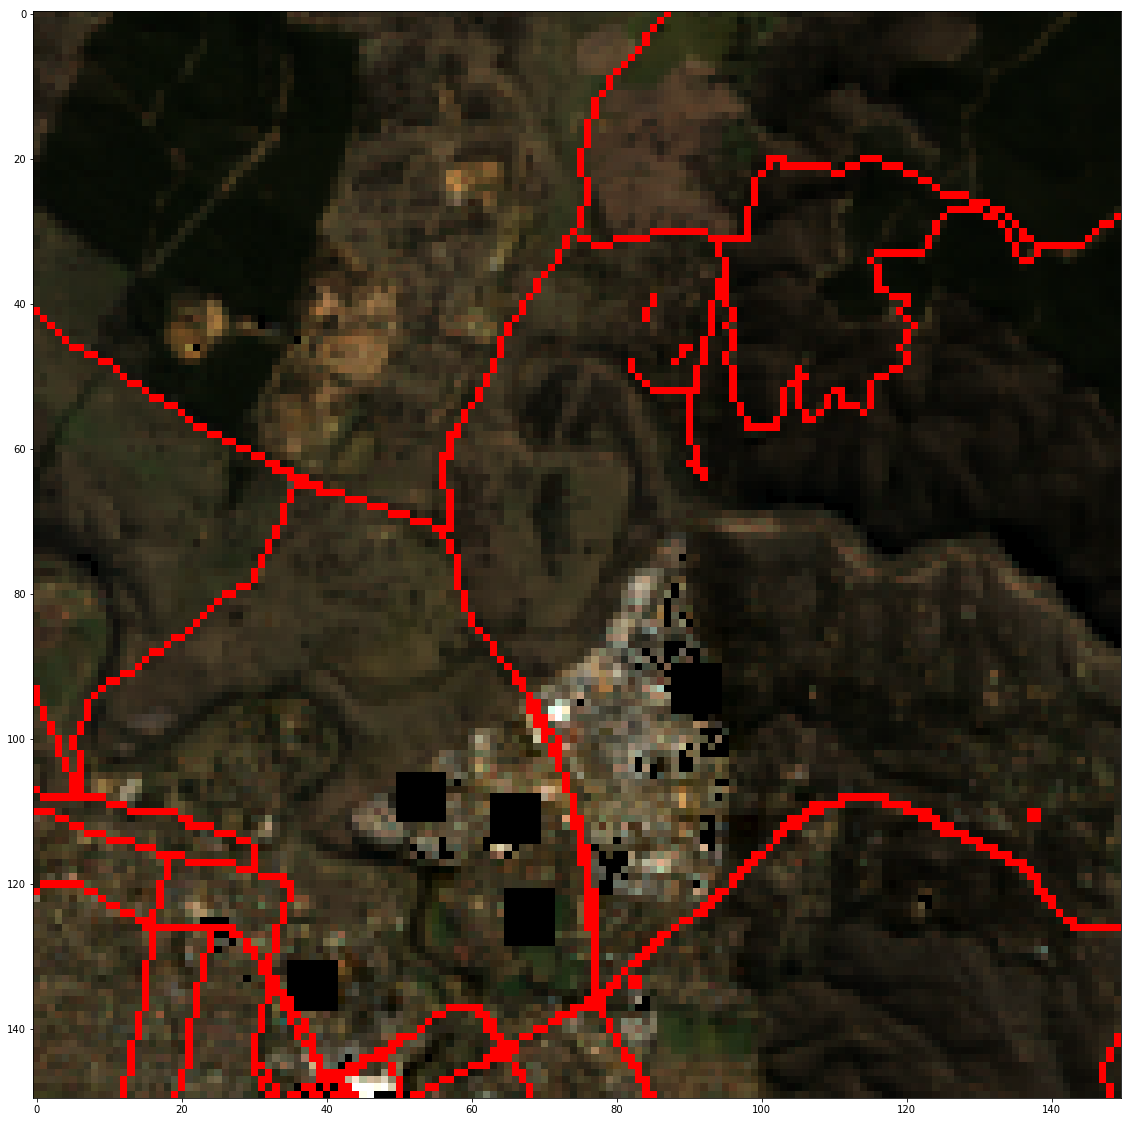

In [10]:
show_image_against_road(1250,3450, light=3, size=150, figsize=(20,20))

In [11]:
row_offset = 0
column_offset = 0
step = 28
minimum_road_mark = 5

image_patch = []
road_patch = []
road_existence = []

i = row_offset
while(i+step <= raw_image[0].shape[0]):
    j = column_offset
    while (j+step <= raw_image[0].shape[1]):
        cur_img_patch = raw_image[:,i:i+step, j:j+step]
        cur_road_patch = road_img[i:i+step, j:j+step]
        
        if (cur_img_patch != -9999).all() and (
            cur_road_patch.sum() >= minimum_road_mark or cur_road_patch.sum() == 0):
            
            image_patch.append(cur_img_patch)
            road_patch.append(cur_road_patch)
            road_existence.append(not cur_road_patch.sum() == 0) 
        j += step
    i += step
    
image_patch = np.array(image_patch)
road_patch = np.array(road_patch)
road_existence = np.array(road_existence)

In [12]:
print(image_patch.shape, road_patch.shape, road_existence.shape)
# (21845, 7, 28, 28) (21845, 28, 28)

(21450, 7, 28, 28) (21450, 28, 28) (21450,)


In [13]:
h5f = h5py.File('090085_20170531_patch.h5', 'w')
h5f.create_dataset(name='image_patch', shape=image_patch.shape, data=image_patch)
h5f.create_dataset(name='road_patch', shape=road_patch.shape, data=road_patch)
h5f.create_dataset(name='road_existence', shape=road_existence.shape, data=road_existence)
h5f.close()

In [14]:
h5f = h5py.File('090085_20170531_patch.h5', 'r')
h5_image_patch = np.array(h5f['image_patch'])
h5_road_patch = np.array(h5f['road_patch'])
h5_road_existence = np.array(h5f['road_existence'])
h5f.close()

In [15]:
# containing road vs. not containing
road_exist = 0
for img in h5_road_patch:
    if (img == 1).sum() >= 5:
        road_exist += 1
print(road_exist, h5_road_patch.shape[0]-road_exist)
print(h5_road_existence.sum())

5161 16289
5161


In [16]:
print((h5_image_patch == image_patch).all(), (h5_road_patch == road_patch).all())

True True


True 1556 111 (28, 28, 3) (28, 28)


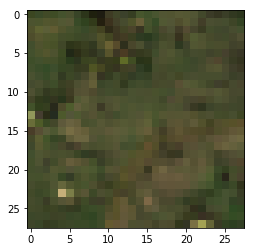

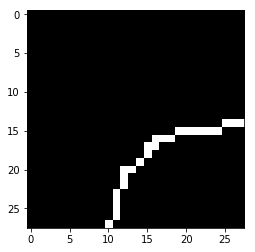

In [17]:
# [0-21450]
index = 700

has_road = road_existence[index]
mask = road_patch[index]
patch = np.array([image_patch[index][3].T, image_patch[index][2].T, image_patch[index][1].T]).T

print(has_road, patch.max(), patch.min(), patch.shape, mask.shape)
patch = patch * 0.0001 * 5

# plot raw img
plt.imshow(patch)
plt.show()
plt.clf()

# plot road mask
plt.imshow(mask, cmap=plt.get_cmap('gray'))
plt.show()
plt.clf()

In [19]:
# raw_image
rgb_img = np.array([raw_image[3].T, raw_image[2].T, raw_image[1].T]).T
rgb_img[:,:,0][np.where(road_img == 1)] = 10000
rgb_img[:,:,1][np.where(road_img == 1)] = 0
rgb_img[:,:,2][np.where(road_img == 1)] = 0
rgb_img[np.where(rgb_img<0)] = 0
rgb_img[np.where(rgb_img>10000)] = 10000
print(rgb_img.dtype)

int16


In [20]:
plt.figure(figsize=(150,150))
plt.xticks(np.arange(int(8000/28))*28)
plt.yticks(np.arange(int(8000/28))*28)
plt.imshow(rgb_img*0.0001*3)
plt.grid()
plt.savefig('grid_masked_img')
plt.clf()